Lambda School Data Science

*Unit 4, Sprint 2, Module 2*

---

# Backpropagation & Gradient Descent (Prepare)

## Learning Objectives
* <a href="#p1">Part 1</a>: Explain the intutition behind backproprogation
* <a href="#p2">Part 2</a>: Implement gradient descent + backpropagation on a feedforward neural network. 
* <a href="#p3">Part 3</a>: Introduce the Keras Sequential Model API

## Summary of Yesterday

Yesterday, we learned about some of the principal components of Neural Networks: Neurons, Weights, Activation Functions, and layers (input, output, & hidden). Today, we will reinforce our understanding of those components and introduce the mechanics of training a neural network. Feed-forward neural networks, such as multi-layer perceptrons (MLPs), are almost always trained using some variation of gradient descent where the gradient has been calculated by backpropagation.

<center><img src="https://cdn-images-1.medium.com/max/1600/1*_M4bZyuwaGby6KMiYVYXvg.jpeg" width="400"></center>

- There are three kinds of layers: input, hidden, and output layers.
- Each layer is made up of **n** individual neurons (aka activation units) which have a corresponding weight and bias.
- Signal is passed from layer to layer through a network by:
 - Taking in inputs from the training data (or previous layer)
 - Multiplying each input by its corresponding weight (think arrow/connecting line)
 - Adding a bias to this weighted some of inputs and weights
 - Activating this weighted sum + bias by squishifying it with sigmoid or some other activation function. With a single perceptron with three inputs, calculating the output from the node is done like so:
\begin{align}
 y = sigmoid(\sum(weight_{1}input_{1} + weight_{2}input_{2} + weight_{3}input_{3}) + bias)
\end{align}
 - this final activated value is the signal that gets passed onto the next layer of the network.
 

## Training a Neural Network: *Formal Summary*

0. Pick a network architecture
   - No. of input units = No. of features
   - No. of output units = Number of Classes (or expected targets)
   - Select the number of hidden layers and number of neurons within each hidden layer
1. Randomly initialize weights
2. Implement forward propagation to get $h_{\theta}(x^{(i)})$ for any $x^{(i)}$
3. Implement code to compute a cost function $J(\theta)$
4. Implement backpropagation to compute partial derivatives $\frac{\delta}{\delta\theta_{jk}^{l}}{J(\theta)}$
5. Use gradient descent (or other advanced optimizer) with backpropagation to minimize $J(\theta)$ as a function of parameters $\theta\$
6. Repeat steps 2 - 5 until cost function is 'minimized' or some other stopping criteria is met. One pass over steps 2 - 5 is called an iteration or epoch.

## Calculating *"cost"*, *"loss"* or *"error"*

We've talked about how in order to evaluate a network's performance, the data is "fed forward" until predictions are obtained and then the "loss" or "error" for a given observation is ascertained by looking at what the network predicted for that observation and comparing it to what it *should* have predicted. 

The error for a given observation is calculated by taking the square of the difference between the predicted value and the actual value. 

We can summarize the overall quality of a network's predictions by finding the average error across all observations. This gives us the "Mean Squared Error." which hopefully is a fairly familiar model evaluation metric by now. Graphing the MSE over each epoch (training cycle) is a common practice with Neural Networks. This is what you're seeing in the top right corner of the Tensorflow Playground website as the number of "epochs" climbs higher and higher.

## What is an "Epoch"?

An "Epoch" is one cycle of passing our data forward through the network, measuring error given our specified cost function, and then -via gradient descent- updating weights within our network to hopefully improve the quality of our predictions on the next iteration.

### A note about Hyperparameters

Neural Networks have many more hyperparameters than other machine learning algorithms which is part of what makes them a beast to train.

1. You need more data to train them on. 
2. They're complex so they take longer to train. 
3. They have lots and lots of hyperparameters which we need to find the most optimal combination of, so we might end up training our model dozens or hundreds of times with different combinations of hyperparameters in order to try and squeeze out a few more tenths of a percent of accuracy. 

# Backpropagation (Learn)
<a id="p1"></a>

## Overview

Backpropagation is short for ["Backwards Propagation of errors"](https://en.wikipedia.org/wiki/Backpropagation) and refers to a specific (rather calculus intensive) algorithm for how weights in a neural network are updated in reverse order at the end of each training epoch. Our purpose today is to demonstrate the backpropagation algorithm on a simple Feedforward Neural Network and in so doing help you get a grasp on the main process. If you want to understand all of the underlying calculus of how the gradients are calculated then you'll need to dive into it yourself, [3Blue1Brown's video is a great starting place](https://www.youtube.com/watch?v=tIeHLnjs5U8). I also highly recommend this Welch Labs series [Neural Networks Demystified](https://www.youtube.com/watch?v=bxe2T-V8XRs) if you want a rapid yet orderly walk through of the main intuitions and math behind the backpropagation algorithm. 

### What is a Gradient?

> In vector calculus, the gradient is a multi-variable generalization of the derivative. 

The gradients that we will deal with today will be vector representations of the derivative of the activation function. 

## Follow Along

In this section, we will again implement a multi-layer perceptron using numpy. We'll focus on using a __Feed Forward Neural Network__ to predict test scores. 

![231 Neural Network](https://cdn-images-1.medium.com/max/1600/1*IjY3wFF24sK9UhiOlf36Bw.png)

### Generate some Fake Data

In [1]:
import numpy as np

np.random.seed(812)

# hours studying, hours sleep
X = np.array(([2,9],
              [1,5],
              [3,6]), dtype=float)

# Exam Scores
y = np.array(([90],
              [72],
              [80]), dtype=float)

# y = 2*hours_studying + 4*hours_sleeping + 50
# ^ what the network is trying to learn

### Feature Normalization

In [2]:
# Normalizing Data on feature 
# Neural Network would probably do this on its own, but it will help us converge on a solution faster
X = X / np.amax(X, axis=0)
y = y / 100

print("Studying, Sleeping \n", X)
print("Test Score \n", y)

Studying, Sleeping 
 [[0.66666667 1.        ]
 [0.33333333 0.55555556]
 [1.         0.66666667]]
Test Score 
 [[0.9 ]
 [0.72]
 [0.8 ]]


### Neural Network Architecture
Lets create a Neural_Network class to contain this functionality

In [3]:
class NeuralNetwork: 
    
    def __init__(self):
        # Setup Arch
        self.inputs = 2
        self.hiddenNodes = 3 
        self.outputNodes = 1
        
        # Initialize Weights
        # 2x3
        self.weights1 = np.random.randn(self.inputs, self.hiddenNodes)
        
        # 3x1
        self.weights2 = np.random.randn(self.hiddenNodes, self.outputNodes)

### Randomly Initialize Weights
How many random weights do we need to initialize? "Fully-connected Layers"

In [4]:
nn = NeuralNetwork()

In [5]:
print("Layer 1 weights: \n", nn.weights1)
print("Layer 2 weights: \n", nn.weights2)

Layer 1 weights: 
 [[ 2.48783189  0.11697987 -1.97118428]
 [-0.48325593 -1.50361209  0.57515126]]
Layer 2 weights: 
 [[-0.20672583]
 [ 0.41271104]
 [-0.57757999]]


### Implement Feedforward Functionality

After this step our neural network should be able to generate an output even though it has not been trained.

In [6]:
class NeuralNetwork: 
    
    def __init__(self):
        # Setup Arch
        self.inputs = 2
        self.hiddenNodes =3 
        self.outputNodes = 1
        
        # Initialize Weights
        # 2x3
        self.weights1 = np.random.random(size=(self.inputs, self.hiddenNodes))
        
        # 3x1
        self.weights2 = np.random.random(size=(self.hiddenNodes, self.outputNodes))
        
    def sigmoid(self, s):
        return 1 / (1+np.exp(-s))
    
    def feed_forward(self, X):
        """
        Calculate the NN inference using feed forward.
        """
        
        # Weight Sum
        self.hidden_sum = np.dot(X, self.weights1)
        
        # Activation
        self.activated_hidden = self.sigmoid(self.hidden_sum)
        
        # Weighted Sum 2
        self.output_sum = np.dot(self.activated_hidden, self.weights2)
        
        # Final Output
        self.activated_output = self.sigmoid(self.output_sum)
        
        return self.activated_output

In [7]:
X

array([[0.66666667, 1.        ],
       [0.33333333, 0.55555556],
       [1.        , 0.66666667]])

### Make a Prediction

In [8]:
# Try to make a prediction with our updated 'net

nn = NeuralNetwork()
output = nn.feed_forward(X[0])
print("intput", X[0])
print("output", output)

intput [0.66666667 1.        ]
output [0.69616205]


### Calculate Error

In [9]:
error = y[0] - output
print(error)

[0.20383795]


In [10]:
output_all = nn.feed_forward(X)
error_all = y - output_all
print(output_all)
print(error_all)

[[0.69616205]
 [0.67871427]
 [0.68931901]]
[[0.20383795]
 [0.04128573]
 [0.11068099]]


Why is my error so big?

My error is so big because my prediction is low.

Why are my prediction low?

Because either:

  1) Second layer **weights** are low
  
  (or)
  
  2) Activations coming from the first layer are low
  
How are activations from the first layer determined? 

  1) By inputs - fixed
  
  2) by **weights** - variable
  
The only thing that I have control over throughout this process in order to increase the value of my final predictions is to either increase weights in layer 2 or increase weights in layer 1. 

Imagine that you could only change your weights by a fixed amount. Say you have .3 and you have to split that up and disperse it over your weights so as to increase your predictions as much as possible. (This isn't actually what happens, but it will help us identify which weights we would benefit the most from moving.)

I need to increase weights of my model somewhere, I'll get the biggest bang for my buck if I increase weights in places where I'm already seeing high activation values -because they end up getting multiplied together before being passed to the sigmoid function. 

> "Neurons that fire together, wire together"

### Implement Backpropagation 

> *Assigning blame for bad predictions and delivering justice - repeatedly and a little bit at a time*

What in our model could be causing our predictions to suck so bad? 

Well, we know that our inputs (X) and outputs (y) are correct, if they weren't then we would have bigger problems than understanding backpropagation.

We also know that our activation function (sigmoid) is working correctly. It can't be blamed because it just does whatever we tell it to and transforms the data in a known way.

So what are the potential culprits for these terrible predictions? The **weights** of our model. Here's the problem though. I have weights that exist in both layers of my model. How do I know if the weights in the first layer are to blame, or the second layer, or both? 

Lets investigate. And see if we can just eyeball what should be updated.

In [11]:
attributes = ['weights1', 'hidden_sum', 'activated_hidden', 'weights2', 'activated_output']
[print(i+'\n', getattr(nn,i), '\n'+'---'*3) for i in attributes if i[:2]!= '__'] 

weights1
 [[0.56557272 0.83042626 0.01763773]
 [0.83364331 0.97704932 0.39621209]] 
---------
hidden_sum
 [[1.21069179 1.53066683 0.40797058]
 [0.65165941 0.81961393 0.22599707]
 [1.12133493 1.48179248 0.28177912]] 
---------
activated_hidden
 [[0.77042133 0.82210386 0.60060116]
 [0.65738431 0.69415438 0.55626002]
 [0.75423625 0.81484317 0.56998235]] 
---------
weights2
 [[0.03285738]
 [0.27006842]
 [0.96861227]] 
---------
activated_output
 [[0.69616205]
 [0.67871427]
 [0.68931901]] 
---------


[None, None, None, None, None]

### Update Weights Based on Gradient

Repeat steps 2-4 for every observation in a given batch, and then given the network's cost function, calculate its gradient using calculus and update weights associated with the (negative) gradient of the cost function. 

Remember that we have 9 weights in our network therefore the gradient that comes from our gradient descent calculation will be the vector that takes us in the most downward direction along some function in 9-dimensional hyperspace.

\begin{align}
C(w1, w2, w3, w4, w5, w6, w7, w8, w9)
\end{align}

You should also know that with neural networks it is common to have gradients that are not convex (like what we saw when we applied gradient descent to linear regression). Due to the high complexity of these models and their nonlinearity, it is common for gradient descent to get stuck in a local minimum, but there are ways to combat this:

1) Stochastic Gradient Descent

2) More advanced Gradient-Descent-based "Optimizers" - See Stretch Goals on assignment.

In [12]:
# I want activations that correspond to negative weights to be lower
# and activations that correspond to positive weights to be higher

class NeuralNetwork: 
    
    def __init__(self):
        # Setup Arch
        self.inputs = 2
        self.hiddenNodes =3 
        self.outputNodes = 1
        
        # Initialize Weights
        # 2x3
        self.weights1 = np.random.randn(self.inputs, self.hiddenNodes)
        
        # 3x1
        self.weights2 = np.random.randn(self.hiddenNodes, self.outputNodes)
        
    def sigmoid(self, s):
        return 1 / (1+np.exp(-s))
    
    def sigmoidPrime(self, s):
        sx = self.sigmoid(s)
        return sx * (1-sx)
    
    def feed_forward(self, X):
        """
        Calculate the NN inference using feed forward.
        """
        
        # Weight Sum
        self.hidden_sum = np.dot(X, self.weights1)
        
        # Activation
        self.activated_hidden = self.sigmoid(self.hidden_sum)
        
        # Weighted Sum 2
        self.output_sum = np.dot(self.activated_hidden, self.weights2)
        
        # Final Output
        self.activated_output = self.sigmoid(self.output_sum)
        
        return self.activated_output
    
    def backward(self, X,y,o):
        """
        Back prop thru the network
        """
        
        self.o_error = y - o
        
        # Apply derivative of sigmoid to error
        self.o_delta = self.o_error * self.sigmoidPrime(self.output_sum)
        
        # z2 error: how much were our output layer weights off
        self.z2_error = self.o_delta.dot(self.weights2.T)
        
        # z2 delta: how much were the weights off?
        self.z2_delta = self.z2_error*self.sigmoidPrime(self.hidden_sum)

        self.weights1 += X.T.dot(self.z2_delta) #Adjust first set (input => hidden) weights
        self.weights2 += self.activated_hidden.T.dot(self.o_delta) #adjust second set (hidden => output) weights
        
    def train(self, X, y):
        o = self.feed_forward(X)
        self.backward(X,y,o)

#### Let's look at the shape of the Gradient Componets


In [13]:
#from reference import NeuralNetwork

nn = NeuralNetwork()

nn.train(X,y)

In [15]:
# Inital weights1:
#  [[0.56557272 0.83042626 0.01763773]
#  [0.83364331 0.97704932 0.39621209]] 
nn.weights1

array([[-1.75407486,  1.06118804,  0.85365722],
       [-0.58156163,  2.02327748, -0.68128622]])

##### Our Error Associated with Each Observation 
aka how wrong were we?

In [16]:
nn.o_error

array([[ 0.09025087],
       [-0.03048412],
       [-0.02195673]])

##### 1st Gradient 
Simple interpretation - how much more sigmoid activation would have pushed us towards the right answer?

`self.o_delta = self.o_error * self.sigmoidPrime(self.output_sum)`

In [23]:
nn.output_sum

array([[1.44838094],
       [1.10119593],
       [1.52966116]])

In [24]:
nn.sigmoid(nn.output_sum)

array([[0.80974913],
       [0.75048412],
       [0.82195673]])

In [25]:
nn.sigmoidPrime(nn.output_sum)

array([[0.15405547],
       [0.18725771],
       [0.14634386]])

In [26]:
nn.o_delta

array([[ 0.01390364],
       [-0.00570839],
       [-0.00321323]])

Let's take a look at the derivate of the sigmoid function to understand what's happening. 

In [27]:
import matplotlib.pyplot as plt

line_x = np.arange(-5, 5, 0.01)

def sigmoid(x):
    return 1 / (1+ np.exp(-x))

def sigmoid_derivative(x):
    sx = sigmoid(x)
    return sx * (1-sx)

# sigmoid
line_y = sigmoid(line_x)
y_d = sigmoid_derivative(line_x)

x = nn.output_sum
s = sigmoid(x)
sx = sigmoid_derivative(x)

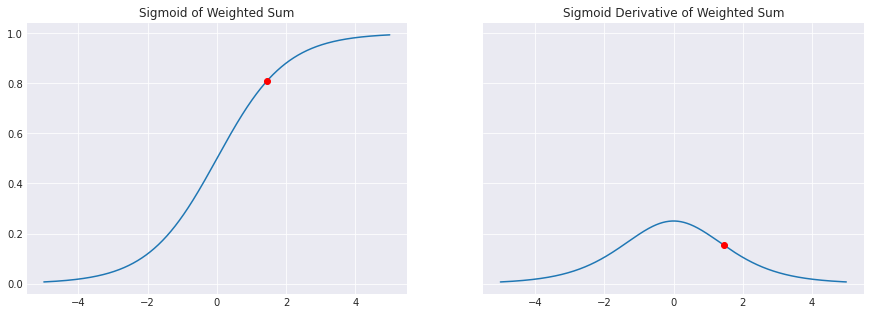

In [28]:
# call regplot on each axes
import seaborn as sns
plt.style.use('seaborn-darkgrid')
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(15,5))
sns.lineplot(x=line_x, y=line_y, ax=ax1)
ax1.plot(x[0], s[0], 'ro')
ax1.set_title("Sigmoid of Weighted Sum")
sns.lineplot(x=line_x, y=y_d, ax=ax2) 
ax2.plot(x[0],sx[0],'ro');
ax2.set_title("Sigmoid Derivative of Weighted Sum");

Look at the derivate graph. The derivative multiplied by the error tells us where to assign blame and update the weights most effective. 

##### 2nd Error
Justice hasn't been served yet - tho. We still have neurons to blame. Let's go back another layer. 

`self.z2_error = self.o_delta.dot(self.weights2.T)`

__Discussion:__ Why is this shape different?

In [29]:
nn.z2_error

array([[-0.01642094,  0.02061582,  0.00681818],
       [ 0.00674191, -0.00846419, -0.00279932],
       [ 0.003795  , -0.00476447, -0.00157573]])

##### 2nd Gradient
For each observation, how much more sigmoid activation from this layer would have pushed us towards the right answer?

`self.z2_delta = self.z2_error * self.sigmoidPrime(self.activated_hidden)`

In [30]:
nn.z2_delta

array([[-0.00207189,  0.00118442,  0.00169906],
       [ 0.00138136, -0.00128036, -0.00069826],
       [ 0.0003573 , -0.00036033, -0.00037872]])

In [32]:
X.T.shape == nn.weights1.shape

True

##### Descent

*Discussion:* Input to Hidden Weight Update
- We multiply the gradient by the inputs. Why?
- Why do we need to transpose the inputs? 

In [33]:
X.T

array([[0.66666667, 0.33333333, 1.        ],
       [1.        , 0.55555556, 0.66666667]])

In [34]:
X.T.dot(nn.z2_delta)

array([[-5.63503108e-04,  2.49780657e-06,  5.21233028e-04],
       [-1.06626144e-03,  2.32891327e-04,  1.05865500e-03]])

*Discussion:* Hidden to Output Weight Update
- Why is output the shape 3x1? 
- We multiply the gradient by the inputs. Why?
- Why do we need to transpose the inputs?

In [35]:
nn.activated_hidden.T.dot(nn.o_delta)

array([[7.93543276e-05],
       [5.45652237e-03],
       [1.91591478e-03]])

### Train the Network (fo real this time)

In [36]:
# Train my 'net
nn = NeuralNetwork()

# Number of Epochs / Iterations
for i in range(10000):
    if (i+1 in [1,2,3,4,5]) or ((i+1) % 1000 ==0):
        print('+' + '---' * 3 + f'EPOCH {i+1}' + '---'*3 + '+')
        print('Input: \n', X)
        print('Actual Output: \n', y)
        print('Predicted Output: \n', str(nn.feed_forward(X)))
        print("Loss: \n", str(np.mean(np.square(y - nn.feed_forward(X)))))
    nn.train(X,y)

+---------EPOCH 1---------+
Input: 
 [[0.66666667 1.        ]
 [0.33333333 0.55555556]
 [1.         0.66666667]]
Actual Output: 
 [[0.9 ]
 [0.72]
 [0.8 ]]
Predicted Output: 
 [[0.80923822]
 [0.8019311 ]
 [0.79936322]]
Loss: 
 0.0049836040373794415
+---------EPOCH 2---------+
Input: 
 [[0.66666667 1.        ]
 [0.33333333 0.55555556]
 [1.         0.66666667]]
Actual Output: 
 [[0.9 ]
 [0.72]
 [0.8 ]]
Predicted Output: 
 [[0.80988829]
 [0.80246227]
 [0.79998563]]
Loss: 
 0.004973382389835718
+---------EPOCH 3---------+
Input: 
 [[0.66666667 1.        ]
 [0.33333333 0.55555556]
 [1.         0.66666667]]
Actual Output: 
 [[0.9 ]
 [0.72]
 [0.8 ]]
Predicted Output: 
 [[0.81047295]
 [0.80293521]
 [0.80054462]]
Loss: 
 0.004964546145322973
+---------EPOCH 4---------+
Input: 
 [[0.66666667 1.        ]
 [0.33333333 0.55555556]
 [1.         0.66666667]]
Actual Output: 
 [[0.9 ]
 [0.72]
 [0.8 ]]
Predicted Output: 
 [[0.81099936]
 [0.80335626]
 [0.8010471 ]]
Loss: 
 0.004956825166332762
+---------E

## Challenge

In the module project, you will implement backpropagation inside a multi-layer perceptron (aka a feedforward neural network). 

# Stochastic Gradient Descent (Learn)

## Overview

The What - Stochastic Gradient Descent calculates an approximation of the gradient over the entire dataset by reviewing the predictions of a random sample. 

The Why - *Speed*. Calculating the gradient over the entire dataset is extremely expensive computationally. 

## Follow Along

A true Stochastic GD-based implementation from [Welch Labs](https://www.youtube.com/watch?v=bxe2T-V8XRs)

In [37]:
class Neural_Network(object):
    def __init__(self):        
        #Define Hyperparameters
        self.inputLayerSize = 2
        self.outputLayerSize = 1
        self.hiddenLayerSize = 3
        
        #Weights (parameters)
        self.W1 = np.random.random(size=(self.inputLayerSize,self.hiddenLayerSize))
        self.W2 = np.random.random(size=(self.hiddenLayerSize,self.outputLayerSize))
        
    def forward(self, X):
        #Propogate inputs though network
        self.z2 = np.dot(X, self.W1)
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2, self.W2)
        yHat = self.sigmoid(self.z3) 
        return yHat
        
    def sigmoid(self, z):
        #Apply sigmoid activation function to scalar, vector, or matrix
        return 1/(1+np.exp(-z))
    
    def sigmoidPrime(self,z):
        #Gradient of sigmoid
        return np.exp(-z)/((1+np.exp(-z))**2)
    
    def costFunction(self, X, y):
        #Compute cost for given X,y, use weights already stored in class.
        self.yHat = self.forward(X)
        J = 0.5*sum((y-self.yHat)**2)
        return J
        
    def costFunctionPrime(self, X, y):
        #Compute derivative with respect to W and W2 for a given X and y:
        self.yHat = self.forward(X)
        
        delta3 = np.multiply(-(y-self.yHat), self.sigmoidPrime(self.z3))
        dJdW2 = np.dot(self.a2.T, delta3)
        
        delta2 = np.dot(delta3, self.W2.T)*self.sigmoidPrime(self.z2)
        dJdW1 = np.dot(X.T, delta2)  
        
        return dJdW1, dJdW2
    
    #Helper Functions for interacting with other classes:
    def getParams(self):
        #Get W1 and W2 unrolled into vector:
        params = np.concatenate((self.W1.ravel(), self.W2.ravel()))
        return params
    
    def setParams(self, params):
        #Set W1 and W2 using single paramater vector.
        W1_start = 0
        W1_end = self.hiddenLayerSize * self.inputLayerSize
        self.W1 = np.reshape(params[W1_start:W1_end], (self.inputLayerSize , self.hiddenLayerSize))
        W2_end = W1_end + self.hiddenLayerSize*self.outputLayerSize
        self.W2 = np.reshape(params[W1_end:W2_end], (self.hiddenLayerSize, self.outputLayerSize))
        
    def computeGradients(self, X, y):
        dJdW1, dJdW2 = self.costFunctionPrime(X, y)
        return np.concatenate((dJdW1.ravel(), dJdW2.ravel()))

In [38]:
from scipy import optimize
class trainer(object):
    def __init__(self, N):
        #Make Local reference to network:
        self.N = N
        
    def callbackF(self, params):
        self.N.setParams(params)
        self.J.append(self.N.costFunction(self.X, self.y))   
        
    def costFunctionWrapper(self, params, X, y):
        self.N.setParams(params)
        cost = self.N.costFunction(X, y)
        grad = self.N.computeGradients(X,y)
        
        return cost, grad
        
    def train(self, X, y):
        #Make an internal variable for the callback function:
        self.X = X
        self.y = y

        #Make empty list to store costs:
        self.J = []
        
        params0 = self.N.getParams()

        options = {'maxiter': 200, 'disp' : True}
        _res = optimize.minimize(self.costFunctionWrapper, params0, jac=True, method='BFGS', \
                                 args=(X, y), options=options, callback=self.callbackF)

        self.N.setParams(_res.x)
        self.optimizationResults = _res

In [39]:
NN = Neural_Network()

In [40]:
T = trainer(NN)

In [41]:
T.train(X,y)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 67
         Function evaluations: 70
         Gradient evaluations: 70


In [42]:
print("Predicted Output: \n" + str(NN.forward(X))) 
print("Loss: \n" + str(np.mean(np.square(y - NN.forward(X))))) # mean sum squared loss

Predicted Output: 
[[0.8999954 ]
 [0.72000154]
 [0.80001   ]]
Loss: 
4.1210951875666294e-11


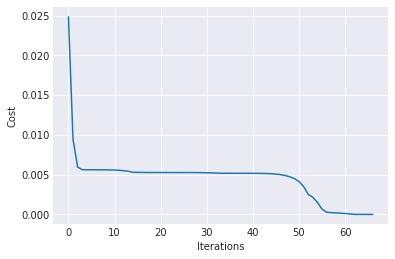

In [43]:
import matplotlib.pyplot as plt
plt.plot(T.J)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()     

## Challenge

This is a reference implementation for you to explore. You will not be expected to apply it to today's module project. 

# Keras Sequential API (Learn)

## Overview

> "Keras is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, CNTK, or Theano. It was developed with a focus on enabling fast experimentation. Being able to go from idea to result with the least possible delay is key to doing good research. Use Keras if you need a deep learning library that:

> Allows for easy and fast prototyping (through user friendliness, modularity, and extensibility).
Supports both convolutional networks and recurrent networks, as well as combinations of the two.
Runs seamlessly on CPU and GPU." 

### Keras Perceptron Sample

In [45]:
#y = 2*hours_studying + 4*hours_sleeping + 50

import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [46]:
def make_samples(n=1000):
    
    study = np.random.uniform(1,5,(n,1))
    sleep = np.random.uniform(1,6,(n,1))
    
    y = 2*study + 4*sleep + 50
    
    X = np.append(study,sleep, axis=1)
    
    X = X / np.amax(X, axis=0)
    y = y / 100
    
    return X,y

In [47]:
X1,y1 = make_samples()

In [48]:
X1

array([[0.73352004, 0.37215276],
       [0.8630108 , 0.46967335],
       [0.32456735, 0.65463966],
       ...,
       [0.99490249, 0.61381048],
       [0.52514313, 0.63614135],
       [0.21322403, 0.74188727]])

In [49]:
X1.shape

(1000, 2)

In [50]:
1000/32

31.25

In [64]:
model = Sequential([
    Dense(100, activation='sigmoid', input_dim=2),
#     Dense(1000, activation='sigmoid'),
#     Dense(1000, activation='sigmoid'),
#     Dense(1000, activation='sigmoid'),
#     Dense(1000, activation='sigmoid'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='sgd', loss='mse', metrics=['mae', 'mse'])

results = model.fit(X1,y1, epochs=100)

Epoch 1/100
32/32 [==============================] - 0s 833us/step - loss: 0.0327 - mae: 0.1647 - mse: 0.0327
Epoch 2/100
32/32 [==============================] - 0s 915us/step - loss: 0.0075 - mae: 0.0715 - mse: 0.0075
Epoch 3/100
32/32 [==============================] - 0s 962us/step - loss: 0.0042 - mae: 0.0537 - mse: 0.0042
Epoch 4/100
32/32 [==============================] - 0s 905us/step - loss: 0.0036 - mae: 0.0505 - mse: 0.0036
Epoch 5/100
32/32 [==============================] - 0s 879us/step - loss: 0.0035 - mae: 0.0497 - mse: 0.0035
Epoch 6/100
32/32 [==============================] - 0s 871us/step - loss: 0.0034 - mae: 0.0495 - mse: 0.0034
Epoch 7/100
32/32 [==============================] - 0s 885us/step - loss: 0.0034 - mae: 0.0494 - mse: 0.0034
Epoch 8/100
32/32 [==============================] - 0s 837us/step - loss: 0.0034 - mae: 0.0494 - mse: 0.0034
Epoch 9/100
32/32 [==============================] - 0s 857us/step - loss: 0.0034 - mae: 0.0494 - mse: 0.0034
Epoch 10/1

In [65]:
import seaborn as sns

In [66]:
results.history.keys()

dict_keys(['loss', 'mae', 'mse'])

In [67]:
epochs = [i for i in range(100)]

In [68]:
len(epochs)

100

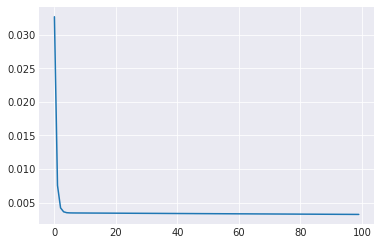

In [69]:
sns.lineplot(range(100), results.history['loss'])

In [63]:
#############################################

## Follow Along

In the `Sequential` api model, you specify a model architecture by 'sequentially specifying layers. This type of specification works well for feed forward neural networks in which the data flows in one direction (forward propagation) and the error flows in the opposite direction (backwards propagation). The Keras `Sequential` API follows a standardarized worklow to estimate a 'net: 

1. Load Data
2. Define Model
3. Compile Model
4. Fit Model
5. Evaluate Model

You saw these steps in our Keras Perceptron Sample, but let's walk thru each step in detail.

### Load Data

In [37]:
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Stretch - use dropout 
import numpy as np

In [38]:
# Load the Data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [39]:
X_train[0].shape

(28, 28)

In [40]:
X_train.shape

(60000, 28, 28)

In [41]:
# X Variable Types
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') /255.

# Correct Encoding on Y
# What softmax expects = [0,0,0,0,0,1,0,0,0,0]
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

### Define Model

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

import numpy as np

np.random.seed(812)

I'll instantiate my model as a "sequential" model. This just means that I'm going to tell Keras what my model's architecture should be one layer at a time.

In [47]:
# https://keras.io/getting-started/sequential-model-guide/
model = Sequential()

Adding a "Dense" layer to our model is how we add "vanilla" perceptron-based layers to our neural network. These are also called "fully-connected" or "densely-connected" layers. They're used as a layer type in lots of other Neural Net Architectures but they're not referred to as perceptrons or multi-layer perceptrons very often in those situations even though that's what they are.

 > ["Just your regular densely-connected NN layer."](https://keras.io/layers/core/)
 
 The first argument is how many neurons we want to have in that layer. To create a perceptron-esque model we will just set it to 10. Our architecture is just an input and output layer. We will tell it that there will be 784 inputs coming into this layer from our dataset and set it to use the sigmoid activation function.

In [48]:
model.add(Flatten(input_shape=(28,28)))
model.add(Dense(10,activation="softmax")) #Relu is valid option. 

### Compile Model
Using binary_crossentropy as the loss function here is just telling keras that I'm doing binary classification so that it can use the appropriate loss function accordingly. If we were predicting non-binary categories we might assign something like `categorical_crossentropy`. We're also telling keras that we want it to report model accuracy as our main error metric for each epoch. We will also be able to see the overall accuracy once the model has finished training.

#### Adam Optimizer
Check out this links for more background on the Adam optimizer and Stohastic Gradient Descent
* [Adam Optimization Algorithm](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)
* [Adam Optimizer - original paper](https://arxiv.org/abs/1412.6980)

In [49]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Fit Model

Lets train it up! `model.fit()` has a `batch_size` parameter that we can use if we want to do mini-batch epochs, but since this tabular dataset is pretty small we're just going to delete that parameter. Keras' default `batch_size` is `None` so omiting it will tell Keras to do batch epochs.

In [50]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
1487/1875 [======================>.......] - ETA: 0s - loss: 0.4990 - accuracy: 0.8729

KeyboardInterrupt: ignored

### Evaluate Model

In [46]:
scores = model.evaluate(X_test,y_test)
print("\n")
print("Validation Data Metrics:")
print(f"{model.metrics_names[0]}: {scores[0]}")
print(f"{model.metrics_names[1]}: {scores[1]*100}")

ValueError: ignored

### Unstable Results

You'll notice that if we rerun the results might differ from the origin run. This can be explain by a bunch of factors. Check out some of them in this article: 

<https://machinelearningmastery.com/randomness-in-machine-learning/>

## Challenge

You will be expected to leverage the Keras `Sequential` api to estimate a feed forward neural networks on a dataset.

---